## Federated learning using Flower

## Install requirements

Needs `simulation` extra for flwr and escape the sq brackets

In [12]:
!pip install -q flwr\[simulation\] torch torchvision matplotlib torchaudio

In [13]:
from collections import OrderedDict
from typing import List, Tuple

import flwr as fl
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
import torchvision.transforms as transforms
from flwr.common import Metrics
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import CIFAR10

DEVICE = torch.device("cpu")  # Try "cuda" to train on GPU
print(f"Training on {DEVICE} using PyTorch {torch.__version__} and Flower {fl.__version__}")

Training on cpu using PyTorch 1.12.1 and Flower 1.1.0


In [14]:
CLASSES = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
NUM_CLIENTS = 10
BATCH_SIZE = 32

## Split Cifar10 Dataset into 10 "organizations" -  “cross-silo”

In [34]:
def load_datasets():
    # Download and transform CIFAR-10 (train and test)
    
    # 1. convert to Tensor
    # 2. normalize pixel values
    transform = transforms.Compose(
      [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    )
    
    trainset = CIFAR10("./dataset", train=True, download=True, transform=transform)
    testset = CIFAR10("./dataset", train=False, download=True, transform=transform)
    
    print("Length of original train Cifar10: ", len(trainset))
    print("Length of original test Cifar10: ", len(testset))

    # Split training set into 10 partitions to simulate the individual dataset
    partition_size = len(trainset) // NUM_CLIENTS
    lengths = [partition_size] * NUM_CLIENTS
    
    datasets = random_split(trainset, lengths, torch.Generator().manual_seed(42))

    # Split each partition into train/val and create DataLoader
    trainloaders = []
    valloaders = []
    
    for ds in datasets:
        len_val = len(ds) // 10  # 10 % validation set
        len_train = len(ds) - len_val
        
        lengths = [len_train, len_val]
        ds_train, ds_val = random_split(ds, lengths, torch.Generator().manual_seed(42))
        
        trainloaders.append(DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=True))
        valloaders.append(DataLoader(ds_val, batch_size=BATCH_SIZE))
    
    testloader = DataLoader(testset, batch_size=BATCH_SIZE)
    return trainloaders, valloaders, testloader

trainloaders, valloaders, testloader = load_datasets()

Files already downloaded and verified
Files already downloaded and verified
Length of original train Cifar10:  50000
Length of original test Cifar10:  10000


In [35]:
for index, trainloader in enumerate(trainloaders):
    print("Length of training silo %d: %d" % (index + 1, len(trainloader.dataset)))

print("Length of test silo: %d" % (len(testloader.dataset)))

Length of training silo 1: 4500
Length of training silo 2: 4500
Length of training silo 3: 4500
Length of training silo 4: 4500
Length of training silo 5: 4500
Length of training silo 6: 4500
Length of training silo 7: 4500
Length of training silo 8: 4500
Length of training silo 9: 4500
Length of training silo 10: 4500
Length of test silo: 10000


In [17]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img.numpy(), (1, 2, 0)))
    plt.show()

## Print some examples of the images

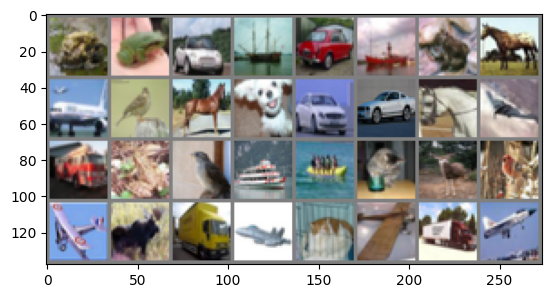

 frog  frog   car  ship   car  ship  frog horse plane  bird horse   dog   car   car horse plane truck  frog  bird  ship  ship   cat  deer  bird plane  deer truck plane   cat plane truck plane


In [18]:
images, labels = iter(trainloaders[0]).next()
imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s' % CLASSES[labels[j]] for j in range(32)))

## Define the model

In [19]:
class Net(nn.Module):
    def __init__(self) -> None:
        super(Net, self).__init__()
        
        # convolutional layer
        self.conv1 = nn.Conv2d(3, 6, 5)
        
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        
        # fully connected layer
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

### Export to ONNX format for visualization in Netron

1. Need to install separate `onnx` package

In [20]:
input_names = ["Cifar10"]
output_names = ["Cifar10 Classification"]

# sample image
X,y = next(iter(trainloader))

torch.onnx.export(net, X, "model.onnx", input_names=input_names, output_names=output_names, opset_version=14)

#### Need to run shape inference on the exported model. Otherwise the shape outputs of each layer is not output.

In [21]:
import onnx
from onnx import shape_inference
path = "model.onnx"
onnx.save(onnx.shape_inference.infer_shapes(onnx.load(path)), path)

## Define train and test functions for the model

In [22]:
def train(net, trainloader, epochs: int, verbose=False):
    """Train the network on the training set."""
    
    # Objective loss function to use to compare predicted outputs with actual ground truth outputs
    criterion = torch.nn.CrossEntropyLoss()
    
    # Method to use to update (optimize) the weights in the model
    optimizer = torch.optim.Adam(net.parameters())
    
    # convert model to train mode
    net.train()
    
    # start training for n epochs/iterations
    for epoch in range(epochs):
        correct, total, epoch_loss = 0, 0, 0.0
        
        # start looping through all batches
        for images, labels in trainloader:
            # load batch of images and labels from dataloader
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            
            # zeros out gradients
            optimizer.zero_grad()
            
            # get outputs after passing the images through the model
            outputs = net(images)
            
            # find the loss by comparing the outputs and labels
            loss = criterion(outputs, labels)
            loss.backward()
            
            # updates parameters
            optimizer.step()
            
            # Metrics
            epoch_loss += loss
            total += labels.size(0)
            correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()
            
        epoch_loss /= len(trainloader.dataset)
        epoch_acc = correct / total
        if verbose:
            print(f"Epoch {epoch+1}: train loss {epoch_loss}, accuracy {epoch_acc}")


def test(net, testloader):
    """Evaluate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0
    
    # convert model to test mode
    # normalisation layers use running statistics
    # de-activates Dropout layers
    net.eval()
    
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    loss /= len(testloader.dataset)
    accuracy = correct / total
    return loss, accuracy

## Run centralized training for one of the organizations

In [38]:
trainloader = trainloaders[0]
valloader = valloaders[0]
net = Net().to(DEVICE)

### Run training loop

In [41]:
for epoch in range(10):
    train(net, trainloader, 1)
    loss, accuracy = test(net, valloader)
    print(f"Epoch {epoch+1}: validation loss {loss}, accuracy {accuracy}")

loss, accuracy = test(net, testloader)
print(f"Final test set performance:\n\tloss {loss}\n\taccuracy {accuracy}")

Epoch 1: validation loss 0.07137089657783509, accuracy 0.456
Epoch 2: validation loss 0.07447803139686585, accuracy 0.454
Epoch 3: validation loss 0.07642607045173645, accuracy 0.454
Epoch 4: validation loss 0.0862912106513977, accuracy 0.452
Epoch 5: validation loss 0.08766522097587585, accuracy 0.458
Epoch 6: validation loss 0.09117158532142638, accuracy 0.474
Epoch 7: validation loss 0.09628592538833618, accuracy 0.452
Epoch 8: validation loss 0.10209209370613098, accuracy 0.454
Epoch 9: validation loss 0.11266481590270996, accuracy 0.424
Epoch 10: validation loss 0.11095696926116944, accuracy 0.446
Final test set performance:
	loss 0.10077044752836227
	accuracy 0.4837


## Start Federating

Steps:

1. Server sends the global model parameters to the client

1. Client updates the local model with the parameters received from the server

1. Client trains the model on the local data (which changes the model parameters locally) 

1. Client sends the updated/changed model parameters back to the server (or, alternatively, it sends just the gradients back to the server, not the full model parameters)

### Helper functions to update the local model with parameters received from the server and to get the updated model parameters from the local mode

1. Use state_dict to access PyTorch model parameter tensors. 

1. Parameter tensors are then converted to/from a list of NumPy ndarray’s (which Flower knows how to serialize/deserialize)

In [25]:
def get_parameters(net) -> List[np.ndarray]:
    return [val.cpu().numpy() for _, val in net.state_dict().items()]

def set_parameters(net, parameters: List[np.ndarray]):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=True)

### Define Client

1. create a subclass of flwr.client.NumPyClient 

1. implement the three methods `get_parameters`, `fit`, and `evaluate`

In [26]:
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, net, trainloader, valloader):
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        return get_parameters(self.net)

    def fit(self, parameters, config):
        set_parameters(self.net, parameters)
        train(self.net, self.trainloader, epochs=1)
        return get_parameters(self.net), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}

### Using the virtual client engine

In [27]:
def client_fn(cid: str) -> FlowerClient:
    """Create a Flower client representing a single organization."""

    # Load model
    net = Net().to(DEVICE)

    # Load data (CIFAR-10)
    # Note: each client gets a different trainloader/valloader, so each client
    # will train and evaluate on their own unique data
    trainloader = trainloaders[int(cid)]
    valloader = valloaders[int(cid)]

    # Create a  single Flower client representing a single organization
    return FlowerClient(net, trainloader, valloader)

### Metrics

- weighted averaging function to aggregate the accuracy metric returned from evaluate

In [28]:
def weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:
    # Multiply accuracy of each client by number of examples used
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    # Aggregate and return custom metric (weighted average)
    return {"accuracy": sum(accuracies) / sum(examples)}

### Starting the simulation

1. client_fn used to create FlowerClient instances 

1. the number of clients to simulate (num_clients) 

1. the number of federated learning rounds (num_rounds)

1. the strategy - encapsulates the federated learning approach/algorithm, for example, Federated Averaging (FedAvg)


Metrics (from this [link](https://github.com/adap/flower/discussions/1349)):

- loss centralized: no need to aggregate, just a single value
- metrics centralized: no need to aggregate, just a single value for each key
- loss distributed: can be automatically aggregated, strategy knows how
- metrics distributed: must be aggregated, but can not be done automatically

In [37]:
# Create FedAvg strategy
strategy = fl.server.strategy.FedAvg(
        fraction_fit=1.0,  # Sample 100% of available clients for training
        fraction_evaluate=0.5,  # Sample 50% of available clients for evaluation
        min_fit_clients=10,  # Never sample less than 10 clients for training
        min_evaluate_clients=5,  # Never sample less than 5 clients for evaluation
        min_available_clients=10,  # Wait until all 10 clients are available
        evaluate_metrics_aggregation_fn=weighted_average,  # <-- pass the metric aggregation function
)

# Start simulation
fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=5),
    strategy=strategy,
)

INFO flower 2023-01-06 13:25:20,962 | app.py:140 | Starting Flower simulation, config: ServerConfig(num_rounds=5, round_timeout=None)
2023-01-06 13:25:24,430	INFO worker.py:1518 -- Started a local Ray instance.
INFO flower 2023-01-06 13:25:25,204 | app.py:174 | Flower VCE: Ray initialized with resources: {'object_store_memory': 2147483648.0, 'node:127.0.0.1': 1.0, 'CPU': 8.0, 'memory': 12594076058.0}
INFO flower 2023-01-06 13:25:25,205 | server.py:86 | Initializing global parameters
INFO flower 2023-01-06 13:25:25,206 | server.py:270 | Requesting initial parameters from one random client
INFO flower 2023-01-06 13:25:26,181 | server.py:274 | Received initial parameters from one random client
INFO flower 2023-01-06 13:25:26,182 | server.py:88 | Evaluating initial parameters
INFO flower 2023-01-06 13:25:26,182 | server.py:101 | FL starting
DEBUG flower 2023-01-06 13:25:26,182 | server.py:215 | fit_round 1: strategy sampled 10 clients (out of 10)
DEBUG flower 2023-01-06 13:25:34,320 | serv

History (loss, distributed):
	round 1: 0.062200083923339845
	round 2: 0.05340594940185547
	round 3: 0.051331385183334355
	round 4: 0.049480037307739255
	round 5: 0.047765124130249026
History (metrics, distributed):
{'accuracy': [(1, 0.3136), (2, 0.38319999999999993), (3, 0.3984), (4, 0.4424), (5, 0.446)]}

1. Flower asks the selected 10 clients to train the model

1. When the server receives the model parameter updates from the clients, it hands those updates over to the strategy (FedAvg) for aggregation. 

1. Strategy aggregates those updates and returns the new global model, which then gets used in the next round of federated learning.

## Main reference

https://flower.dev/docs/tutorial/Flower-1-Intro-to-FL-PyTorch.html

## Comparisons with Clara

Pros:

1. Ease of use

1. More accessible documentation


Cons:

1. No native data loading for medical imaging formats (such as DICOM/ NIFTI, etc.)

1. Clara may be more mature software than flower